In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
from torchtext import data
import re
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
from gensim import corpora
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_packed_sequence

# import math

### Import Data

In [2]:
df = pd.read_csv("twitter_training.csv", header = None)
df = df.drop([0, 1], axis = 1)
df = df.applymap(str)
df.columns = ["Sentiment", "Text"]
df["Target"] = df["Sentiment"].map({"Negative" : 0, "Positive" : 1, "Neutral" : 2, "Irrelevant" : 3})
df.head()

,Sentiment,Text,Target
0,Positive,im getting on borderlands and i will murder yo...,1
1,Positive,I am coming to the borders and I will kill you...,1
2,Positive,im getting on borderlands and i will kill you ...,1
3,Positive,im coming on borderlands and i will murder you...,1
4,Positive,im getting on borderlands 2 and i will murder ...,1


In [3]:
stopwords_eng = stopwords.words('english')

def preprocess_text(text):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    punct = "[^\w\s]+"
    text = re.sub(link_re_pattern, "", text)
    text = re.sub(punct, "", text)
    return text.lower()

def build_tweet_corpus(data):

    word_counter = build_tweet_counter(data)
    ls = []
    for key in word_counter:
        if word_counter[key] < 5:
            ls.append(key)
    
    stopwords = set(stopwords_eng + ls)
    tweet_corpus = set()
    for x in data:
        for word in x:
            if word not in stopwords:
                tweet_corpus.add(word)
    return list(tweet_corpus)

def build_tweet_counter(data):
    
    tweet_corpus = []
    for x in data:
        for word in x:
            if word not in stopwords_eng:
                tweet_corpus.append(word)
    return Counter(tweet_corpus)


def process_data(df):

    tokenizer = TweetTokenizer()

    df["Text"] = df["Text"].apply(preprocess_text)
    df["Tokens"] = df["Text"].apply(tokenizer.tokenize)
    df["Tokens"] = df["Tokens"].apply(lambda x: [word for word in x if word not in stopwords_eng])

    return df

def tokenize(df, tweet_corpus, max_len):
    corpus_dict = corpora.Dictionary([tweet_corpus]).token2id
    
    def to_tokenids(text):
        tokens = [corpus_dict[x] for x in text if x in corpus_dict]
        if len(tokens) <= 1:
            return "NA"
        else:
            return np.array(tokens)

    df["Tokens"] = df["Tokens"].apply(to_tokenids)
    df = df[df["Tokens"] != "NA"]
    lens = torch.LongTensor([len(x) for x in df["Tokens"]])

    def pad(x):
        if len(x) < max_len:
            x = np.append(x, [0]*(max_len - len(x)))
        return x[0:max_len]

    df['Tokens'] = df["Tokens"].apply(pad)
    return df, lens

In [4]:
df_processed = process_data(df)
traindata, valdata = train_test_split(df, test_size = 0.2, random_state= 321)

# length = df_processed["Tokens"].apply(len)
# plt.hist(length, bins = 30)

In [5]:
df_processed = process_data(df)
traindata, valdata = train_test_split(df, test_size = 0.2, random_state= 321)

train_corpus = build_tweet_corpus(df["Tokens"])

max_len = 35
traindata, trainlens = tokenize(traindata, train_corpus, 35)
valdata, vallens = tokenize(valdata, train_corpus, 35)


c:\Users\andy8\anaconda3\envs\stock_trade\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\andy8\AppData\Local\Temp\ipykernel_9008\3237871160.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df["Tokens"].apply(pad)


In [6]:
trainX = np.stack(traindata["Tokens"])
trainY = np.array(traindata["Target"])
validX = np.stack(valdata["Tokens"])
validY = np.array(valdata["Target"])

In [7]:
torchtrain = TensorDataset(torch.from_numpy(trainX).to(torch.int64), torch.from_numpy(trainY).to(torch.int64))
torchtval = TensorDataset(torch.from_numpy(validX).to(torch.int64), torch.from_numpy(validY).to(torch.int64))

trainloader = DataLoader(torchtrain, shuffle=True, batch_size=16)
validloader = DataLoader(torchtval, shuffle=True, batch_size=16)

In [8]:
vocab_size = len(train_corpus)
embedding_dim = 32
window_size = 4



convs = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(2,2), padding=1),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Conv2d(3, 5, kernel_size=(2,2), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Flatten()
)

dataiter = iter(trainloader)

inputs, labels = next(dataiter)
print(inputs.shape)
labels = labels.to(torch.int64)
lengths = 35 - (inputs == 0).sum(dim=1)

embed = nn.Embedding(vocab_size, embedding_dim)
# out = cnn(inputs)
embeds = embed(inputs)

pool = nn.MaxPool2d(kernel_size=(2,2))

x = torch.unsqueeze(embeds, 1)

x2 = convs(x)

print(x2.shape)
# embeds = nn.utils.rnn.pack_padded_sequence(embeds, list(lengths), batch_first=True, enforce_sorted=False)
# print(embeds[:, None, :, :].shape)
# embeds = embeds[:, None, :, :]
# cnn(embeds)
# inputs, labels = inputs.to(device), labels.to(device)

torch.Size([16, 35])
torch.Size([16, 1530])


In [11]:
class SentimentCNN(nn.Module):
    def __init__(self, voab_size, embedding_dim):
        super(SentimentCNN, self).__init__()
        
        self.embedding = nn.Embedding(voab_size, embedding_dim)
        self.out_dim = 1

        self.convs = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=(2,2), padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(3, 5, kernel_size=(2,2), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten()
        )
    
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(1530, 4)
    
    def forward(self, input):
        batch_size = input.size(0)
        embeds = self.embedding(input)
        embeds = torch.unsqueeze(embeds, 1)
        # embeds = nn.utils.rnn.pack_padded_sequence(embeds, list(lengths), batch_first=True, enforce_sorted=False)
        out = self.convs(embeds)

        # print(rnn_out)
        # output_padded, output_lengths = pad_packed_sequence(rnn_out, batch_first=True)
        out = self.linear(out)
        
        return out



In [12]:
dataiter = iter(trainloader)

device = "cuda" if torch.cuda.is_available() else "cpu"

lr=0.0001
no_layers = 3
vocab_size = len(train_corpus)
embedding_dim = 32
hidden_dim = 128

model = SentimentCNN(vocab_size, embedding_dim)
model.to(device)

#moving to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.step()

inputs, labels = next(dataiter)
labels = labels.to(torch.int64)
inputs, labels = inputs.to(device), labels.to(device)

output = model(inputs)
print(output)


tensor([[-0.0213, -0.1923, -0.1165, -0.3064],
        [ 0.0854, -0.1728, -0.0902, -0.2845],
        [ 0.0832, -0.1728, -0.0454, -0.2144],
        [-0.0073, -0.2488, -0.0659, -0.2373],
        [ 0.1092, -0.2640, -0.0209, -0.2556],
        [ 0.0509, -0.2021, -0.0179, -0.1298],
        [-0.0109, -0.1734, -0.0786, -0.2712],
        [ 0.0033, -0.2159, -0.0797, -0.1822],
        [ 0.0581, -0.1984, -0.0376, -0.1642],
        [ 0.1027, -0.1448,  0.0589, -0.2996],
        [ 0.1074, -0.1741, -0.1590, -0.2512],
        [ 0.0132, -0.2135, -0.0807, -0.1726],
        [ 0.0418, -0.1721,  0.0264, -0.1918],
        [ 0.0373, -0.2345, -0.0210, -0.3021],
        [ 0.0737, -0.1853, -0.0901, -0.2719],
        [ 0.0449, -0.1761, -0.0117, -0.1786]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [14]:
lr=0.002
no_layers = 2
vocab_size = len(train_corpus)

model = SentimentCNN(vocab_size, embedding_dim)

#moving to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
epochs = 10
valid_loss_min = np.Inf
batch_size = 16

epoch_tr_loss, epoch_vl_loss = [],[]
epoch_tr_acc, epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    val_losses = []
    train_acc = 0.0
    corr = 0
    tot = 0

    corrval = 0
    totval = 0
    model.train()
    # initialize hidden state 
    for inputs, labels in trainloader:
        labels = labels.to(torch.int64)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()

        output = model(inputs)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
        preds = torch.argmax(output, 1)
        corr += (preds == labels).sum().item()
        tot += 16

    for val_inputs, val_labels in validloader:
        val_labels = val_labels.to(torch.int64)
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

        val_output = model(val_inputs)
        val_loss = criterion(val_output, val_labels)
        val_losses.append(val_loss.item())
        # calculate the loss and perform backprop
        val_preds = torch.argmax(val_output, 1)
        corrval += (val_preds == val_labels).sum().item()
        totval += 16

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss}')
    print(f'val_loss: {epoch_val_loss}')
    print(f'train_accuracy : {corr/tot*100}')
    print(f"valid accuracy: {corrval/totval*100}")
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)

    epoch_tr_acc.append(corr/tot*100)
    epoch_vl_acc.append(corrval/totval*100)

    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'working/CNN/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss


In [17]:
testdf = pd.read_csv("twitter_validation.csv", header = None)
testdf = testdf.drop([0, 1], axis = 1)
dtestdff = testdf.applymap(str)
testdf.columns = ["Sentiment", "Text"]
testdf["Target"] = testdf["Sentiment"].map({"Negative" : 0, "Positive" : 1, "Neutral" : 2, "Irrelevant" : 3})

df_processed_test = process_data(testdf)

max_len = 35
testdata, testlens = tokenize(df_processed_test, train_corpus, 35)

testX = np.stack(testdata["Tokens"])
testY = np.array(testdata["Target"])
torchtest = TensorDataset(torch.from_numpy(testX).to(torch.int64), torch.from_numpy(testY).to(torch.int64))

testloader = DataLoader(torchtest, shuffle=True, batch_size=16)

corrval = 0
totval = 0

bestmodel = SentimentCNN(vocab_size, embedding_dim)
bestmodel.load_state_dict(torch.load('working/CNN/state_dict.pt'))
bestmodel.to(device)

for inputs, labels in testloader:
    labels = labels.to(torch.int64)
    inputs, labels = inputs.to(device), labels.to(device)

    output = bestmodel(inputs)
    # calculate the loss and perform backprop
    preds = torch.argmax(output, 1)
    corrval += (preds == labels).sum().item()
    totval += 16

print(f"The test accuacy is: {corrval/totval}")

c:\Users\andy8\anaconda3\envs\stock_trade\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\andy8\AppData\Local\Temp\ipykernel_9008\3237871160.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df["Tokens"].apply(pad)


The test accuacy is: 0.9364754098360656


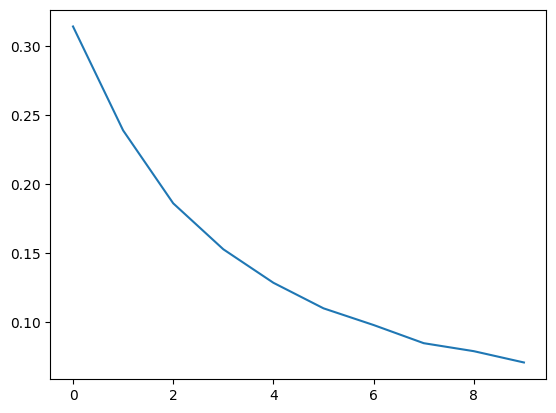

In [51]:
plt.plot(epoch_tr_loss)


In [16]:
def predict(sentence, model, tweet_corpus, max_len):
    sentence = sentence.lower()
    words = sentence.split(" ")
    corpus_dict = corpora.Dictionary([tweet_corpus]).token2id
    tokens = [corpus_dict[x] for x in words if x in corpus_dict]
    if len(tokens) <= 1:
        print("No Valid Strings!")
        return None
    else:
        tokens = np.array(tokens)

    if len(tokens) < max_len:
        tokens = np.append(tokens, [0]*(max_len - len(tokens)))
        tokens = tokens[0:max_len]
    
    tokens = torch.LongTensor(tokens[None, :])
    tokens = tokens.to(device)
    output = model(tokens)
    preds = torch.argmax(output, 1)
    return preds
    

In [32]:
predict("I like cheese", model, train_corpus, 35)


tensor([1], device='cuda:0')